In [179]:
# load dataset
import pandas as pd
X = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projects/20200525_GOOG_Multivariate_LSTM/GOOG.csv')

In [180]:
#original copy without preprocessing
X = X.drop(['High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
index = X.pop('Date')
X

,Open
0,1196.000000
1,1200.680054
2,1203.959961
3,1210.000000
4,1218.000000
...,...
248,1098.260010
249,1119.015015
250,1138.000000
251,1221.000000


##Generating GDP per day

[0, 91, 182, 273, 365, 456, 547]

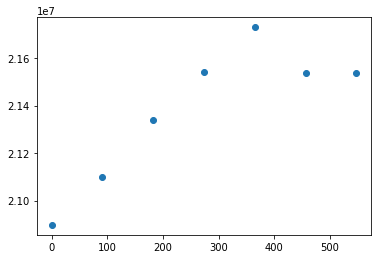

In [182]:
#GDP interpolation
#abbiamo solo valori per Quarter, dobbiamo ottenere quelli per giorno
import matplotlib.pyplot as plt

y = [20897804, 21098827, 21340267, 21542540, 21729124, 21537940, 21537940]
x = [int((365/4)*0), int((365/4)*1), int((365/4)*2), int((365/4)*3), int((365/4)*4), int((365/4)*5), int((365/4)*6)]

plt.plot(x, y, 'o')
x

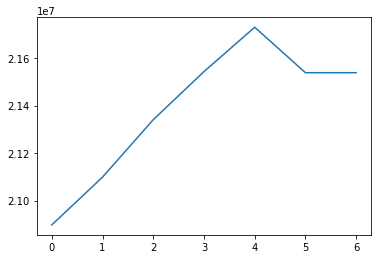

In [183]:
from scipy.interpolate import interp1d
import numpy as np

f = interp1d(x, y, kind='cubic')
plt.plot(f(x))

In [184]:
#today to day_number
import datetime
today = datetime.datetime.now()
today
today = datetime.datetime(2019, 4, 11)
today.strftime('%j')

'101'

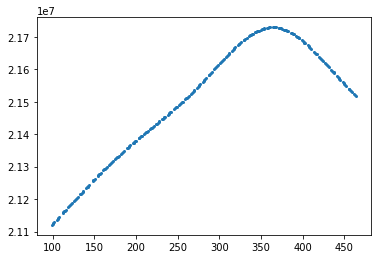

In [185]:
list_day = list()
list_GDP = list()
for _ in range(len(index)):
  year = int(index[_][0]+index[_][1]+index[_][2]+index[_][3])
  month = int(index[_][5]+index[_][6])
  day = int(index[_][8]+index[_][9])
  date = datetime.datetime(year, month, day)
  date_add = int(date.strftime('%j'))
  history_day = date_add+((year-2019)*365)
  list_day.append(history_day)
  list_GDP.append(f(history_day))

plt.plot(list_day, list_GDP, 'o', linewidth=1, markersize=2)

In [186]:
list_GDP = pd.DataFrame(list_GDP)
list_GDP.columns = ['GDP']
list_GDP

,GDP
0,2.112062e+07
1,2.112336e+07
2,2.112610e+07
3,2.112885e+07
4,2.113710e+07
...,...
248,2.153281e+07
249,2.153028e+07
250,2.152286e+07
251,2.152044e+07


In [187]:
#merge Google Stock with GDP
X = pd.concat([X, list_GDP], axis=1)
X

,Open,GDP
0,1196.000000,2.112062e+07
1,1200.680054,2.112336e+07
2,1203.959961,2.112610e+07
3,1210.000000,2.112885e+07
4,1218.000000,2.113710e+07
...,...,...
248,1098.260010,2.153281e+07
249,1119.015015,2.153028e+07
250,1138.000000,2.152286e+07
251,1221.000000,2.152044e+07


##Preprocessing

In [138]:
from sklearn import preprocessing
import numpy as np

In [139]:
#convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, drop_col=False, y_var=1):
  n_features = int(len(data.columns))
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  #put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
    data = agg.copy()
    
  if drop_col == True:
    tot = n_features*n_in+n_features #24+8 = 32

    y_name = list(data.columns)[n_features*n_in-1 + y_var]
    y = data[y_name]
    for i in range(n_features*n_in, tot):
      data.drop(data.columns[[tot-n_features]], axis=1, inplace=True)
    data = pd.concat([data, y], axis=1)
  return data

In [140]:
def split(df, test_size):
  df = df.values
  len_df = df.shape[0]
  test_size = int(len_df*test_size)
  train, test = df[0:-test_size], df[-test_size:]
  return train, test

In [188]:
K = X.copy()
K

,Open,GDP
0,1196.000000,2.112062e+07
1,1200.680054,2.112336e+07
2,1203.959961,2.112610e+07
3,1210.000000,2.112885e+07
4,1218.000000,2.113710e+07
...,...,...
248,1098.260010,2.153281e+07
249,1119.015015,2.153028e+07
250,1138.000000,2.152286e+07
251,1221.000000,2.152044e+07


In [189]:
#original copy
X = K.copy()

input = 3
X = series_to_supervised(X, input, 1, drop_col=False)
X

#X, y
y = X.pop('var1(t)')
X = X.drop(['var2(t)'], axis=1)

#scaling
scaler_1 = preprocessing.MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler_1.fit_transform(X))
X
scaler_1 = preprocessing.MinMaxScaler(feature_range=(0, 1))
y = pd.DataFrame(scaler_1.fit_transform(pd.DataFrame(y)))
y

#train, test
X_train_, X_test_ = split(X, 0.1)
y_train_, y_test_ = split(y, 0.1)
X_ = X.copy()
y_ = y.copy()
print(X_train_.shape, X_test_.shape, y_train_.shape, y_test_.shape)

(225, 6) (25, 6) (225, 1) (25, 1)


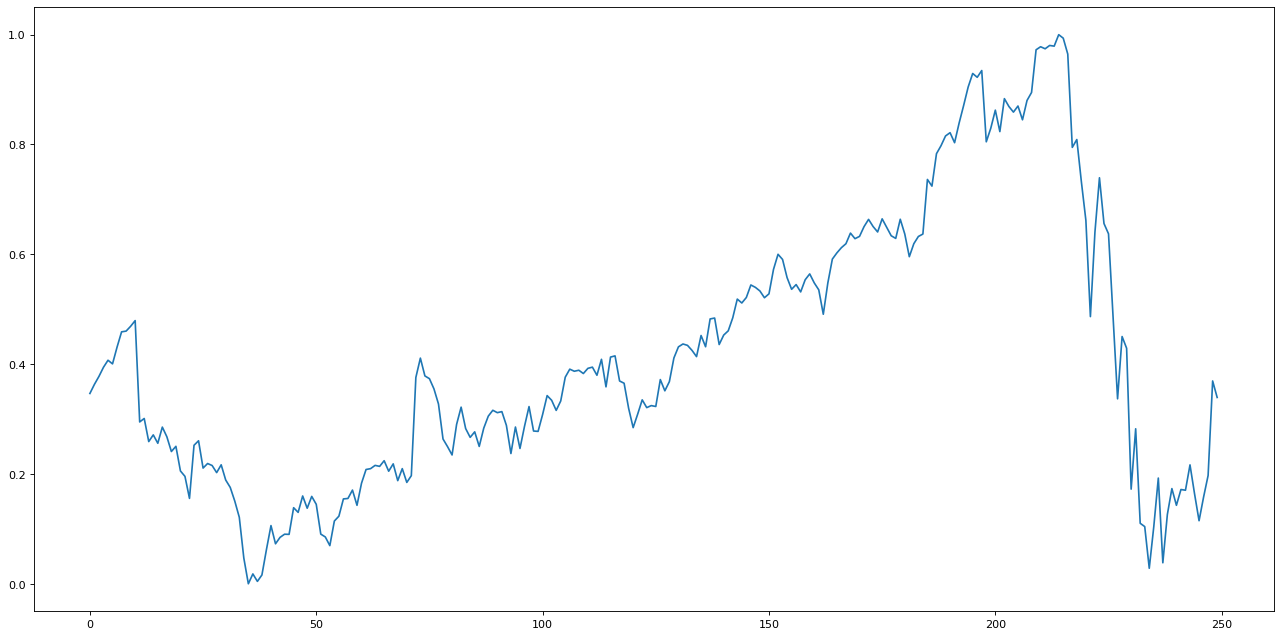

In [144]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20, 10), dpi= 80)
fig=plt.plot(y_)

In [145]:
def transform_to_stationary(df):
  #create a differenced series
  def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
      value = dataset[i] - dataset[i - interval]
      diff.append(value)
    return pd.DataFrame(diff)
  
  df = df.values #al di fuori delle funzioni voglio operare solo su un DataFrame
  df = difference(df, 1) #X ritorna ad essere un df
  return df

In [200]:
#only scaling
X = K.copy()

#preprocessing
X = transform_to_stationary(X)

X = series_to_supervised(X, input, 1, drop_col=False)
X

#X, y
y = X.pop('var1(t)')
X = X.drop(['var2(t)'], axis=1)

#scaling
scaler_2 = preprocessing.MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler_2.fit_transform(X))
X
scaler_2 = preprocessing.MinMaxScaler(feature_range=(0, 1))
y = pd.DataFrame(scaler_2.fit_transform(pd.DataFrame(y)))
y

#train, test
X_train, X_test = split(X, 0.1)
y_train, y_test = split(y, 0.1)
X = X.copy()
y = y.copy()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(225, 6) (24, 6) (225, 1) (24, 1)


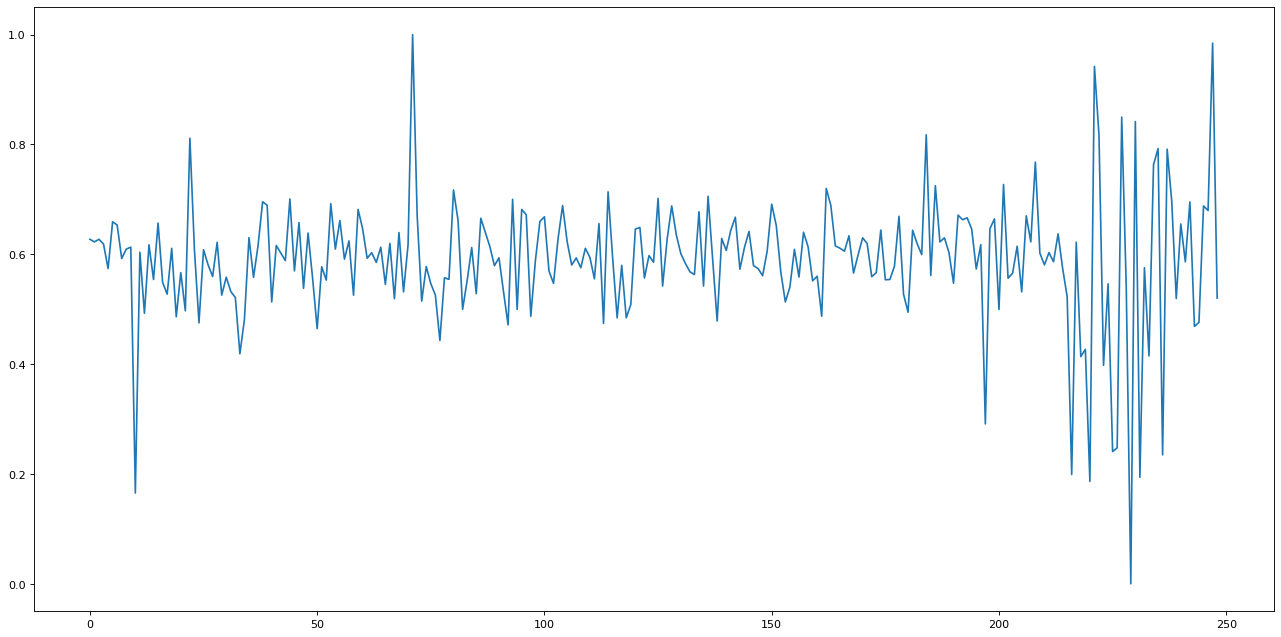

In [201]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20, 10), dpi= 80)
fig=plt.plot(y)

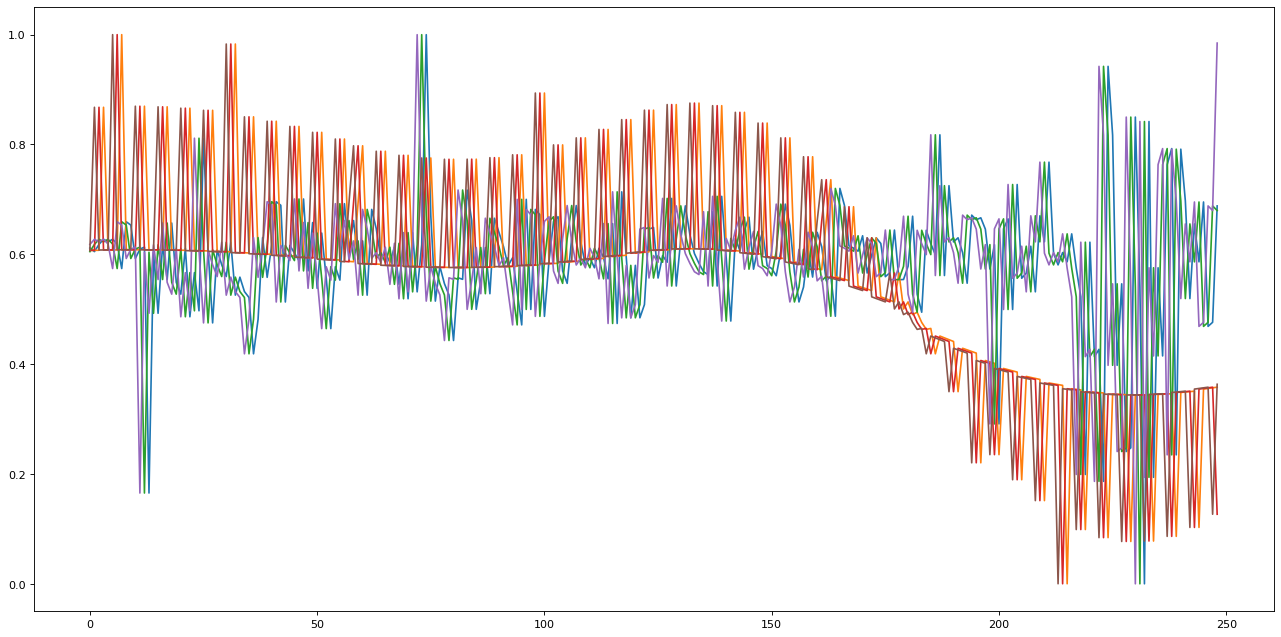

In [202]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20, 10), dpi= 80)
fig=plt.plot(X)

In [203]:
#reshape [samples, n_input_timesteps, n_features]
X_train = X_train.reshape((225, 6, 1)) #che e.X_ e e.X abbiano eguali colonne o una in più è irrilevante, non ci sconvolgiamo per questo
y_train = y_train.reshape((225, 1, 1))
print(X_train.shape, y_train.shape)
#ogni singolo sample ha dimensioni [1, 6, 1]

(225, 6, 1) (225, 1, 1)


##LSTM Model

In [204]:
#LSTM
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(125, activation='relu', batch_input_shape=(1, 6, 1)))
model.add(RepeatVector(1)) #numero di output
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
#model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=3000, batch_size=1, verbose=2, shuffle=False)
model.reset_states()

X_test = X_test.reshape(24, 6, 1)
y_test = y_test.reshape(24, 1, 1)
print(X_test.shape, y_test.shape)

Epoch 1/1000
225/225 - 1s - loss: 0.0416
Epoch 2/1000
225/225 - 1s - loss: 0.0112
Epoch 3/1000
225/225 - 1s - loss: 0.0107
Epoch 4/1000
225/225 - 1s - loss: 0.0104
Epoch 5/1000
225/225 - 1s - loss: 0.0102
Epoch 6/1000
225/225 - 1s - loss: 0.0100
Epoch 7/1000
225/225 - 1s - loss: 0.0099
Epoch 8/1000
225/225 - 1s - loss: 0.0098
Epoch 9/1000
225/225 - 1s - loss: 0.0097
Epoch 10/1000
225/225 - 1s - loss: 0.0097
Epoch 11/1000
225/225 - 1s - loss: 0.0096
Epoch 12/1000
225/225 - 1s - loss: 0.0095
Epoch 13/1000
225/225 - 1s - loss: 0.0095
Epoch 14/1000
225/225 - 1s - loss: 0.0095
Epoch 15/1000
225/225 - 1s - loss: 0.0094
Epoch 16/1000
225/225 - 1s - loss: 0.0094
Epoch 17/1000
225/225 - 1s - loss: 0.0093
Epoch 18/1000
225/225 - 1s - loss: 0.0093
Epoch 19/1000
225/225 - 1s - loss: 0.0093
Epoch 20/1000
225/225 - 1s - loss: 0.0093
Epoch 21/1000
225/225 - 1s - loss: 0.0092
Epoch 22/1000
225/225 - 1s - loss: 0.0092
Epoch 23/1000
225/225 - 1s - loss: 0.0092
Epoch 24/1000
225/225 - 1s - loss: 0.0092
E

In [205]:
#make a one-step forecast
yhat = model.predict(X_test, verbose=2, batch_size=1) #SENZA LA BATCH_SIZE, prende un input alla volta, con la batch_size tutto il dataset
print(yhat)

24/24 - 0s
[[[0.576787  ]]

 [[0.7666627 ]]

 [[0.5788494 ]]

 [[0.5107361 ]]

 [[0.42336044]]

 [[0.5167028 ]]

 [[0.44298515]]

 [[0.6484894 ]]

 [[0.54632735]]

 [[0.42671666]]

 [[0.65061736]]

 [[0.514826  ]]

 [[0.5344545 ]]

 [[0.5771903 ]]

 [[0.42263573]]

 [[0.6159303 ]]

 [[0.5579769 ]]

 [[0.6919013 ]]

 [[0.6079157 ]]

 [[0.5478072 ]]

 [[0.34218395]]

 [[0.7859666 ]]

 [[0.5539071 ]]

 [[0.6495021 ]]]


In [206]:
#adjust scaler to 1 column
X = K.drop(['GDP'], axis=1)
scaler_3, X = v.partition.scale('all_df', scaler='MinMaxScaler', df=X, to_float=True, return_df=True)

In [157]:
yhat.shape

(24, 1, 1)

In [207]:
#2   inverse scaling of the prediction
raw = scaler_3.inverse_transform(yhat[:, :, -1])
raw

array([[1321.0094],
       [1412.5618],
       [1322.0038],
       [1289.1616],
       [1247.0317],
       [1292.0386],
       [1256.4941],
       [1355.5822],
       [1306.3226],
       [1248.6499],
       [1356.6082],
       [1291.1337],
       [1300.598 ],
       [1321.204 ],
       [1246.6824],
       [1339.8832],
       [1311.9398],
       [1376.514 ],
       [1336.0187],
       [1307.0363],
       [1207.8909],
       [1421.8695],
       [1309.9774],
       [1356.0704]], dtype=float32)

In [208]:
#2   inverse scaling of the gaps
#non so perchè prima ho fatto un reshaping, sembra senza ragione
#comunque, ora correggo
y_test = y_test.reshape(X_test.shape[0], 1)
gap = scaler_2.inverse_transform(y_test)
gap #err

array([[ -73.139892],
       [ -71.76001 ],
       [  54.699951],
       [ -10.300049],
       [-123.699951],
       [  53.      ],
       [ -83.      ],
       [  -2.890015],
       [ -36.599975],
       [  36.540039],
       [  42.669922],
       [ -74.400025],
       [  42.450074],
       [  22.699951],
       [ -14.669922],
       [  13.869995],
       [  -0.630005],
       [  22.26001 ],
       [ -25.300049],
       [ -23.73999 ],
       [  20.755005],
       [  18.984985],
       [  83.      ],
       [ -14.5     ]])

In [209]:
#2   invert preprocessing on predicted data
#remove stationary
y_test = y_test.reshape(X_test.shape[0], 1)
var1 = raw    #original values
var2 = gap     #gaps
var3 = list()     #

#var1 = var1.values
#var2 = var2.values

var3.append(var1[0])
for i in range(0, len(var2)-1):
  values = var1[i] + var2[i+1]
  print('values: ', var1[i], var2[i+1])
  var3.append(values)
var3

values:  [1321.0094] [-71.76001]
values:  [1412.5618] [54.699951]
values:  [1322.0038] [-10.300049]
values:  [1289.1616] [-123.699951]
values:  [1247.0317] [53.]
values:  [1292.0386] [-83.]
values:  [1256.4941] [-2.890015]
values:  [1355.5822] [-36.599975]
values:  [1306.3226] [36.540039]
values:  [1248.6499] [42.669922]
values:  [1356.6082] [-74.400025]
values:  [1291.1337] [42.450074]
values:  [1300.598] [22.699951]
values:  [1321.204] [-14.669922]
values:  [1246.6824] [13.869995]
values:  [1339.8832] [-0.630005]
values:  [1311.9398] [22.26001]
values:  [1376.514] [-25.300049]
values:  [1336.0187] [-23.73999]
values:  [1307.0363] [20.755005]
values:  [1207.8909] [18.984985]
values:  [1421.8695] [83.]
values:  [1309.9774] [-14.5]


[array([1321.0094], dtype=float32),
 array([1249.24938941]),
 array([1467.26171858]),
 array([1311.70373518]),
 array([1165.46167009]),
 array([1300.03173828]),
 array([1209.03857422]),
 array([1253.60412563]),
 array([1318.98217832]),
 array([1342.86267084]),
 array([1291.31982434]),
 array([1282.2081293]),
 array([1333.58374099]),
 array([1323.29797346]),
 array([1306.53405749]),
 array([1260.55236805]),
 array([1339.25317371]),
 array([1334.19982934]),
 array([1351.21398909]),
 array([1312.27868676]),
 array([1327.79125988]),
 array([1226.87585414]),
 array([1504.86950684]),
 array([1295.47741699])]

In [210]:
predicted = var3

In [211]:
#invert preprocessing on expected data
#inverse scaling
expected = scaler_.inverse_transform(y_test_)
expected

array([[1350.199951],
       [1277.060059],
       [1205.300049],
       [1260.      ],
       [1249.699951],
       [1126.      ],
       [1179.      ],
       [1096.      ],
       [1093.109985],
       [1056.51001 ],
       [1093.050049],
       [1135.719971],
       [1061.319946],
       [1103.77002 ],
       [1126.469971],
       [1111.800049],
       [1125.670044],
       [1125.040039],
       [1147.300049],
       [1122.      ],
       [1098.26001 ],
       [1119.015015],
       [1138.      ],
       [1221.      ],
       [1206.5     ]])

In [212]:
for i in range(len(y_test_)-1):
  print('iteration=%d, Predicted=%f, Expected=%f' % (i+1, predicted[i], expected[i]))

iteration=1, Predicted=1321.009399, Expected=1350.199951
iteration=2, Predicted=1249.249389, Expected=1277.060059
iteration=3, Predicted=1467.261719, Expected=1205.300049
iteration=4, Predicted=1311.703735, Expected=1260.000000
iteration=5, Predicted=1165.461670, Expected=1249.699951
iteration=6, Predicted=1300.031738, Expected=1126.000000
iteration=7, Predicted=1209.038574, Expected=1179.000000
iteration=8, Predicted=1253.604126, Expected=1096.000000
iteration=9, Predicted=1318.982178, Expected=1093.109985
iteration=10, Predicted=1342.862671, Expected=1056.510010
iteration=11, Predicted=1291.319824, Expected=1093.050049
iteration=12, Predicted=1282.208129, Expected=1135.719971
iteration=13, Predicted=1333.583741, Expected=1061.319946
iteration=14, Predicted=1323.297973, Expected=1103.770020
iteration=15, Predicted=1306.534057, Expected=1126.469971
iteration=16, Predicted=1260.552368, Expected=1111.800049
iteration=17, Predicted=1339.253174, Expected=1125.670044
iteration=18, Predicted

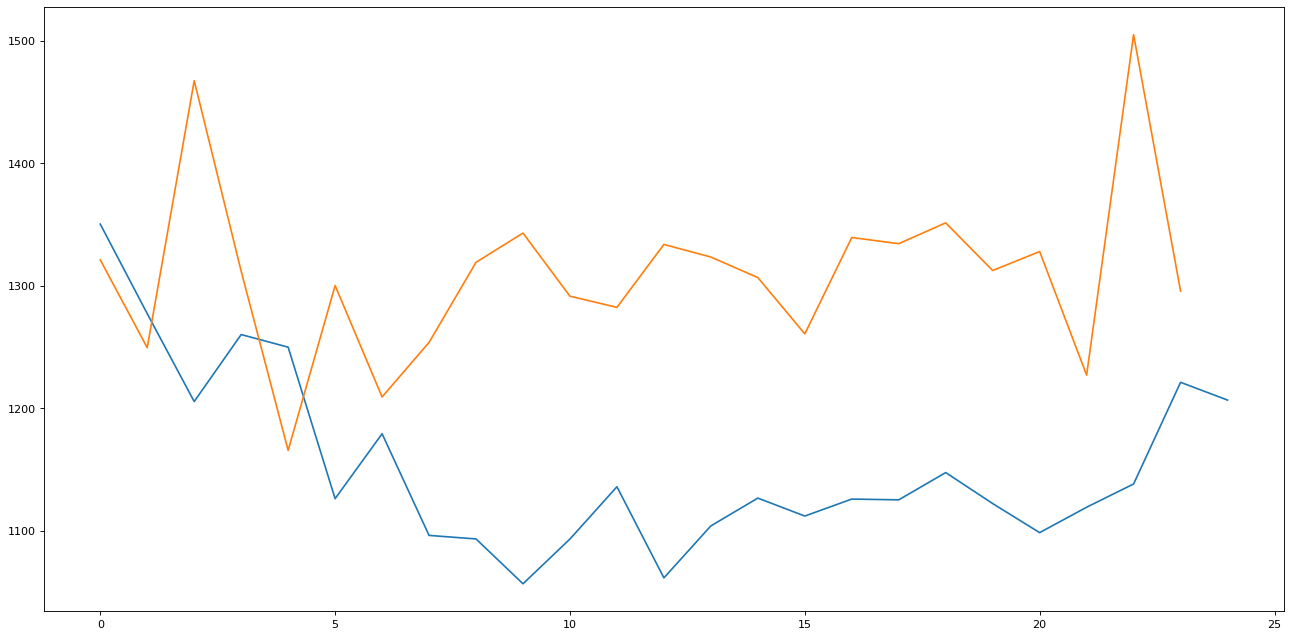

In [213]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20, 10), dpi= 80)
fig=plt.plot(expected)
fig=plt.plot(predicted)
#predicted = orange
#expected = blue

In [175]:
# report performance
from math import *
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(expected[:-1], predicted))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 200.900
